In [270]:
! mv /Users/wangy1/Downloads/4x4.csv .

mv: /Users/wangy1/Downloads/4x4.csv: No such file or directory


In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [42]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [2]:
df = pd.read_csv("4x4.csv")

In [3]:
df["espaloma_openeye_hfe_rmse"] = np.abs(df["calculated hydration free energy OpenEye (kcal/mol)"] - df["calculated hydration free energy EspalomaCharge 2023-01-05 (kcal/mol)"])
df["amber_openeye_hfe_rmse"] = np.abs(df["calculated hydration free energy AmberTools (kcal/mol)"] - df["calculated hydration free energy EspalomaCharge 2023-01-05 (kcal/mol)"])

In [4]:
df["amber_openeye_charge_rmse"].mean()

0.006647619459972786

In [5]:
def prc(x, n_samples=100):
    x_axis = np.linspace(x.min(), x.max(), n_samples)
    y = np.array([(x < _x).sum() / x.shape[0] for _x in x_axis])
    return y

In [6]:
def bootstrap(x, n_samples=100, ci=0.95):
    _x = np.random.choice(x, size=(n_samples, x.shape[0])).mean(0)
    low = np.percentile(_x, 100.0 * 0.5 * (1 - ci))
    high = np.percentile(_x, (1 - ((1 - ci) * 0.5)) * 100.0)
    return _x.mean(), low, high


/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1

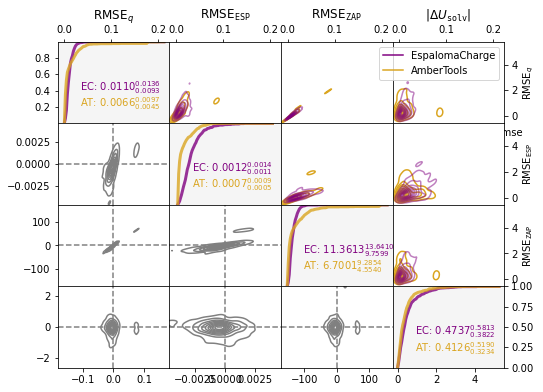

In [7]:
NAMES = ["openeye_charge_rmse", "openeye_esp_rmse", "openeye_zap_rmse", "openeye_hfe_rmse"]
IDX_TO_NAME = dict(zip(range(len(NAMES)), NAMES))

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(4, 4, hspace=0, wspace=0)
axs = gs.subplots()
        
def plot_diag(idx, x_name, y_name):
    ax = axs[idx, idx]
    
    x_space = np.linspace(
        0,
        max(df[x_name].max(), df[y_name].max()),
        100,
    )
    
    ax.plot(x_space, prc(df[x_name]), color="purple", label="EspalomaCharge", linewidth=3, alpha=0.8)
    ax.plot(x_space, prc(df[y_name]), color="goldenrod", label="AmberTools", linewidth=3, alpha=0.8)
    ax.set_ylim(0, 1.0)
    # ax.tick_params(axis="y",direction="in", pad=-25)
    ax.set_axisbelow(False)
    ax.set_facecolor("whitesmoke")
    
    
    original, low, high = bootstrap(df[x_name])
    ax.annotate(
        f"EC: ${original:.4f}_{{{low:.4f}}}^{{{high:.4f}}}$", (0.2, 0.4), xycoords="axes fraction",
        color="purple",
    )
    
    original, low, high = bootstrap(df[y_name])
    ax.annotate(
        f"AT: ${original:.4f}_{{{low:.4f}}}^{{{high:.4f}}}$", (0.2, 0.2), xycoords="axes fraction",
        color="goldenrod",
    )
    

for idx in range(4):
    plot_diag(idx, "espaloma_" + IDX_TO_NAME[idx], "amber_" + IDX_TO_NAME[idx])
    
def plot_kde(idx_x, idx_y, x_name, y_name):
    ax = axs[idx_x, idx_y]
    ax.sharex(axs[idx_x, idx_x])
    sns.kdeplot(
        x=df["amber_" + x_name],
        y=df["amber_" + y_name],
        c="goldenrod",
        alpha=1.0,
        ax=ax,
        legend=False,
    )
    
    sns.kdeplot(
        x=df["espaloma_" + x_name],
        y=df["espaloma_" + y_name],
        c="purple",
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    

for idx_x in range(4):
    for idx_y in range(idx_x+1, 4):
        plot_kde(idx_x, idx_y, IDX_TO_NAME[idx_x], IDX_TO_NAME[idx_y])
        
        
def plot_delta_kde(idx_x, idx_y, x_name, y_name):
    ax = axs[idx_x, idx_y]
    
    x = - df["espaloma_" + x_name] + df["amber_" + x_name]
    y = - df["espaloma_" + y_name] + df["amber_" + y_name]
    
    ax.set_xlim(-np.abs(x).max(), np.abs(x).max())
    ax.set_ylim(-np.abs(y).max(), np.abs(y).max())
    
    ax.axhline(0, linestyle="--", color="grey")
    ax.axvline(0, linestyle="--", color="grey")
    
    sns.kdeplot(
        x=x, y=y,
        c="grey",
        alpha=1.0,
        ax=ax,
        legend=False,
    )
    
    
for idx_x in range(4):
    for idx_y in range(idx_x+1, 4):
        plot_delta_kde(idx_y, idx_x, IDX_TO_NAME[idx_x], IDX_TO_NAME[idx_y])


        
for x in range(4):
    for y in range(4):
        ax = axs[x, y]
        
        if x == 0:
            ax.xaxis.tick_top()
        
        if y == 3:
            ax.yaxis.tick_right()
            
        
        if x == 1 or x == 2:
            ax.set_xticks([])
            ax.set_xlabel(None)
            
        if y == 1 or y == 2:
            ax.set_yticks([])
            ax.set_ylabel(None)
        
        

ax = axs[0, 0]
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
        
ax = axs[0, 3]
ax.plot(0, 0, c="purple", label="EspalomaCharge")
ax.plot(0, 0, c="goldenrod", label="AmberTools")
ax.legend()   
ax.yaxis.set_label_position("right")
ax.set_ylabel("RMSE$_q$")

ax = axs[1, 3]
ax.yaxis.set_label_position("right")
ax.set_ylabel("RMSE$_\mathtt{ESP}$")

ax = axs[2, 3]
ax.yaxis.set_label_position("right")
ax.set_ylabel("RMSE$_\mathtt{ZAP}$")

ax = axs[0, 0]
ax.set_title("RMSE$_q$")

ax = axs[0, 1]
ax.set_title("RMSE$_\mathtt{ESP}$")

ax = axs[0, 2]
ax.set_title("RMSE$_\mathtt{ZAP}$")

ax = axs[0, 3]
ax.set_title("$| \Delta U_\mathtt{solv} |$")
        
plt.savefig("4x4.png", dpi=300)

In [ ]:
df["amber_openeye_charge_rmse"].max()

/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/seaborn/distributions.py:1

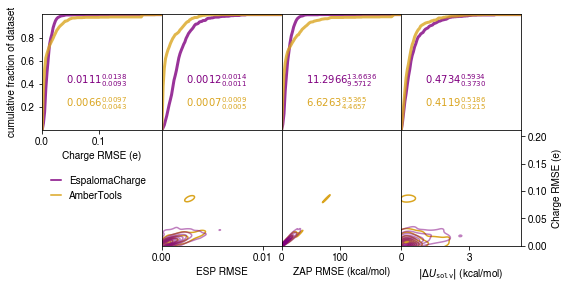

In [44]:
NAMES = ["openeye_charge_rmse", "openeye_esp_rmse", "openeye_zap_rmse", "openeye_hfe_rmse"]
IDX_TO_NAME = dict(zip(range(len(NAMES)), NAMES))

fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(2, 4, hspace=0, wspace=0)
axs = gs.subplots()

def plot_cdf(idx, x_name, y_name):
    ax = axs[0, idx]
    
    x_space = np.linspace(
        0,
        max(df[x_name].max(), df[y_name].max()),
        100,
    )
    
    
    x, y = df[x_name], df[y_name]
    
    ax.plot(x_space, prc(df[x_name]), color="purple", label="EspalomaCharge", linewidth=3, alpha=0.8)
    ax.plot(x_space, prc(df[y_name]), color="goldenrod", label="AmberTools", linewidth=3, alpha=0.8)
    ax.set_ylim(0, 1.0)
    # ax.tick_params(axis="y",direction="in", pad=-25)
    original, low, high = bootstrap(df[x_name])
    ax.annotate(
        f"${original:.4f}_{{{low:.4f}}}^{{{high:.4f}}}$", (0.2, 0.4), xycoords="axes fraction",
        color="purple",
    )
    
    original, low, high = bootstrap(df[y_name])
    ax.annotate(
        f"${original:.4f}_{{{low:.4f}}}^{{{high:.4f}}}$", (0.2, 0.2), xycoords="axes fraction",
        color="goldenrod",
    )
    
    
    ax.set_xlim(0, max(x.max(), y.max()))
    
    if idx != 0:
        ax.set_yticks([])
        
    

for idx in range(4):
    plot_cdf(idx, "espaloma_" + IDX_TO_NAME[idx], "amber_" + IDX_TO_NAME[idx])
    
def plot_kde(idx, x_name, y_name):
    ax = axs[1, idx]
    ax.sharex(axs[0, idx])
    # ax.sharey(axs[1, 1])

    sns.kdeplot(
        x=df["amber_" + x_name],
        y=df["amber_" + y_name],
        c="goldenrod",
        alpha=1.0,
        ax=ax,
        legend=False,
    )
    
    sns.kdeplot(
        x=df["espaloma_" + x_name],
        y=df["espaloma_" + y_name],
        c="purple",
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    ax.set_xlim(0, max(df["amber_" + x_name].max(), df["espaloma_" + x_name].max()))
    ax.set_ylim(0, max(df["amber_" + y_name].max(), df["espaloma_" + y_name].max()))
    
    
for idx in range(1, 4):
    plot_kde(idx, IDX_TO_NAME[idx], "openeye_charge_rmse")

    
ax = axs[1, 0]    
ax.plot(0, 0, c="purple", label="EspalomaCharge")
ax.plot(0, 0, c="goldenrod", label="AmberTools")
ax.legend(loc="center left", frameon=False, handlelength=1)
ax.set_axis_off()

# axs[1, 3].set_yticks([0.0, 0.1])
axs[0, 0].set_xticks([0.0, 0.1])
axs[0, 0].set_yticks([0.2, 0.4, 0.6, 0.8])
axs[0, 0].set_ylabel("cumulative fraction of dataset")
axs[1, 1].set_xticks([0, 0.01])
axs[1, 1].set_yticks([])
axs[1, 2].set_yticks([])
axs[1, 2].set_xticks([0, 100])
axs[1, 3].set_xticks([0, 3])
axs[0, 0].set_xlabel("Charge RMSE (e)")
axs[1, 1].set_xlabel("ESP RMSE")
axs[1, 2].set_xlabel("ZAP RMSE (kcal/mol)")
axs[1, 3].set_xlabel("$|\Delta U_\mathtt{solv}|$ (kcal/mol)")
axs[1, 3].yaxis.tick_right()
axs[1, 3].set_ylabel("Charge RMSE (e)")
axs[1, 3].yaxis.set_label_position("right")
plt.setp(axs[0, 1].get_xticklabels(), visible=False)
plt.setp(axs[0, 2].get_xticklabels(), visible=False)
plt.setp(axs[0, 3].get_xticklabels(), visible=False)
plt.tight_layout()
plt.savefig("cdf_freesolv.png", dpi=300)
    